My final project for Brainstation's September 2020 machine learning course. In this project, I do basic data cleaning, logistic regression and PCA for modeling, and use ROC and AUC with F1 scores to evaluate model performance. Finally, I use keras to train a model and improve performance metrics.

Original data from https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction?select=test.csv

In [1]:
#Import all of the packages we think we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
pd.options.display.max_columns=500
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score
from sklearn import model_selection, metrics, linear_model, datasets, feature_selection
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [2]:
fp = pd.read_csv('trainfp.csv')

In [3]:
fp.head()
#First lets look at the data

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
fp['Policy_Sales_Channel'].value_counts(dropna=False)

152.0    134784
26.0      79700
124.0     73995
160.0     21779
156.0     10661
          ...  
144.0         1
149.0         1
84.0          1
143.0         1
43.0          1
Name: Policy_Sales_Channel, Length: 155, dtype: int64

In [5]:
fp.isnull().values.any() #Check for any NaN values across the entire data set. Doesn't sum

False

In [6]:
fp['Vintage'].unique() #The days someone has been a customer. Every customer is less than a year old, very suspicious data

array([217, 183,  27, 203,  39, 176, 249,  72,  28,  80,  46, 289, 221,
        15,  58, 147, 256, 299, 158, 102, 116, 177, 232,  60, 180,  49,
        57, 223, 136, 222, 149, 169,  88, 253, 107, 264, 233,  45, 184,
       251, 153, 186,  71,  34,  83,  12, 246, 141, 216, 130, 282,  73,
       171, 283, 295, 165,  30, 218,  22,  36,  79,  81, 100,  63, 242,
       277,  61, 111, 167,  74, 235, 131, 243, 248, 114, 281,  62, 189,
       139, 138, 209, 254, 291,  68,  92,  52,  78, 156, 247, 275,  77,
       181, 229, 166,  16,  23,  31, 293, 219,  50, 155,  66, 260,  19,
       258, 117, 193, 204, 212, 144, 234, 206, 228, 125,  29,  18,  84,
       230,  54, 123, 101,  86,  13, 237,  85,  98,  67, 128,  95,  89,
        99, 208, 134, 135, 268, 284, 119, 226, 105, 142, 207, 272, 263,
        64,  40, 245, 163,  24, 265, 202, 259,  91, 106, 190, 162,  33,
       194, 287, 292,  69, 239, 132, 255, 152, 121, 150, 143, 198, 103,
       127, 285, 214, 151, 199,  56,  59, 215, 104, 238, 120,  2

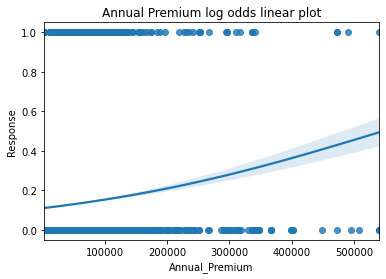

In [8]:
Annual_premium = sns.regplot(x= 'Annual_Premium', y= 'Response', data= fp, logistic= True).set_title("Annual Premium log odds linear plot")
#This takes a long time, like 5+ minutes long
#Not a "U" shape, slight "S" shape Assumption of IV's log odds linearity seems intact

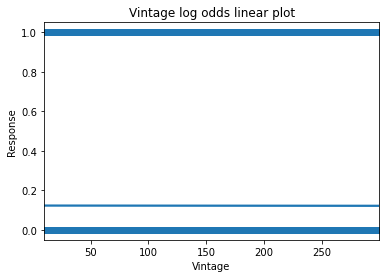

In [11]:
Days_With = sns.regplot(x= 'Vintage', y= 'Response', data= fp, logistic= True).set_title("Vintage log odds linear plot")
#Clearly not S shape, Discard

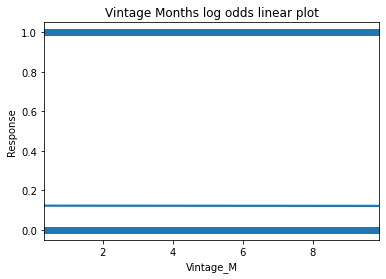

In [9]:
Months_With = sns.regplot(x= 'Vintage_M', y= 'Response', data= fp, logistic= True).set_title("Vintage Months log odds linear plot")
#Changed Vintage into months, obviously didn't change shape of the plot

In [7]:
fp['Vehicle_Age'] = fp['Vehicle_Age'].replace({'< 1 Year':0, '1-2 Year':1, '> 2 Years':2})

#Consider turning Policy_Sales_Channel into dummy variables
#Consider turning Region_Code into dummy variables

In [8]:
fp['Gender'] = fp['Gender'].replace({'Male':0, 'Female':1})

In [9]:
fp['Vehicle_Damage'] = fp['Vehicle_Damage'].replace({'Yes':0, 'No':1})

In [10]:
from sklearn.cluster import KMeans
#We originally wanted to use KMeans to determine customer segmentation but with responses already known, training a 
#logistic regression model made more sense

In [11]:
features_to_include = ['Gender', 'Age', 'Driving_License', 'Previously_Insured','Annual_Premium', ]
# Remove 'Policy_Sales_Channel', 'Vintage', and 'Region_Code' because they do not meet conditions and/or do not have clear 
#documentation. In addition, we will remove Vehicle_age and Vehicle_Damage for this iteration due to multico

In [12]:
#Check multicollinearity 
multico = fp.corr()
#Vehicle Age and Age of customer are moderately positively correlated. Older customers have older vehicles. Consider dropping one
#Vehicle Damage and Previously Insured are highly correlated which is not surprising. Consider dropping one term

In [13]:
print(multico)

                            id    Gender       Age  Driving_License  \
id                    1.000000 -0.000999  0.001561        -0.000564   
Gender               -0.000999  1.000000 -0.145545         0.018374   
Age                   0.001561 -0.145545  1.000000        -0.079782   
Driving_License      -0.000564  0.018374 -0.079782         1.000000   
Region_Code          -0.000572 -0.000604  0.042574        -0.001081   
Previously_Insured    0.002457  0.081932 -0.254682         0.014969   
Vehicle_Age           0.000878 -0.160427  0.765790        -0.037306   
Vehicle_Damage        0.001507  0.091606 -0.267534         0.016622   
Annual_Premium        0.003027 -0.003673  0.067507        -0.011906   
Policy_Sales_Channel -0.002837  0.111159 -0.577826         0.043731   
Vintage              -0.000630  0.002517 -0.001264        -0.000848   
Response             -0.001368 -0.052440  0.111147         0.010155   

                      Region_Code  Previously_Insured  Vehicle_Age  \
id    

In [14]:
del fp['Vintage']
del fp['id']

In [34]:
sns.set(font_scale=1)

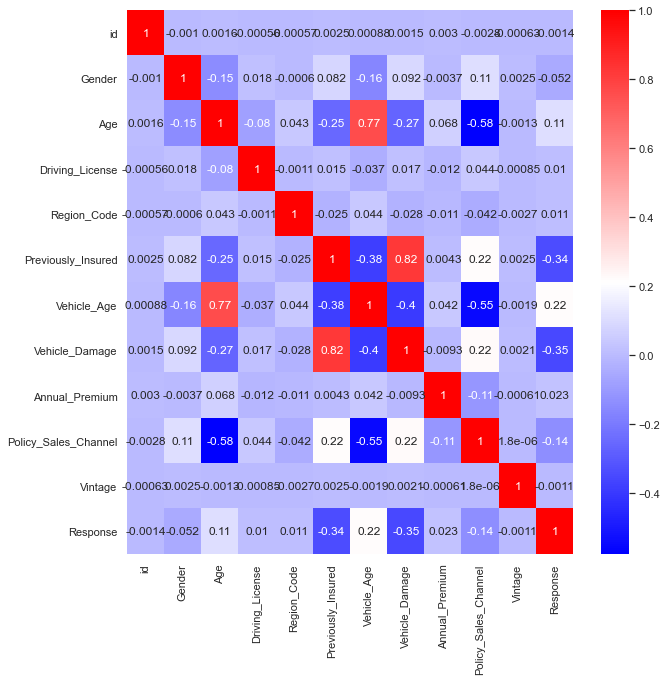

In [35]:
#We are going to make a heat graph of multicollinearity for visual's sake
plt.figure(figsize=(10,10)) 
sns.heatmap(multico, annot = True, cmap = 'bwr')

In [18]:
fp

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response
0,1,0,44,1,28,0,2,0,40454,26,1
1,2,0,76,1,3,0,1,1,33536,26,0
2,3,0,47,1,28,0,2,0,38294,26,1
3,4,0,21,1,11,1,0,1,28619,152,0
4,5,1,29,1,41,1,0,1,27496,152,0
...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,0,74,1,26,1,1,1,30170,26,0
381105,381106,0,30,1,37,1,0,1,40016,152,0
381106,381107,0,21,1,30,1,0,1,35118,160,0
381107,381108,1,68,1,14,0,2,0,44617,124,0


In [93]:
from sklearn.preprocessing import StandardScaler


In [25]:
scaler = StandardScaler()
scaler.fit(fp[features_to_include])
XS = scaler.transform(fp[features_to_include])
#We are going to scale the data because we are going to use PCA for some models
#This is the wrong way of scaling data, but I didn't learn that until after I started

In [26]:
XS

array([[-0.92154476,  0.33377727,  0.04620794, -0.91963797,  0.57453868],
       [-0.92154476,  2.39675074,  0.04620794, -0.91963797,  0.17263624],
       [-0.92154476,  0.52718104,  0.04620794, -0.91963797,  0.4490531 ],
       ...,
       [-0.92154476, -1.14898491,  0.04620794,  1.08738442,  0.26454281],
       [ 1.08513449,  1.88100737,  0.04620794, -0.91963797,  0.81638891],
       [-0.92154476,  0.46271311,  0.04620794, -0.91963797,  0.6513986 ]])

In [29]:
k_means_model = KMeans(n_clusters = 2)
k_means_model.fit(XS)

KMeans(n_clusters=2)

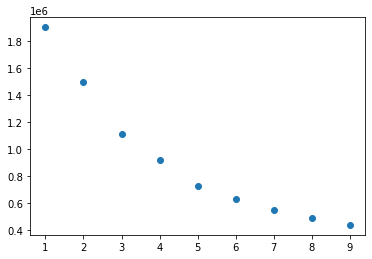

In [31]:
inertia_list = []
k_range = np.arange(1,10)
for k in k_range:
    k_means_model = KMeans(n_clusters = k)
    k_means_model.fit(XS)
    inertia_list.append(k_means_model.inertia_)

plt.scatter(k_range,inertia_list)
plt.show()

In [32]:
#Looks like 3 is the elbow. Let's do k-means with 2, 3, and 4 clusters
four_means_model = KMeans(n_clusters = 4)
four_means_model.fit(XS);

three_means_model = KMeans(n_clusters = 3)
three_means_model.fit(XS);

five_means_model = KMeans(n_clusters = 5)
five_means_model.fit(XS)

KMeans(n_clusters=5)

In [34]:
two_means_model = KMeans(n_clusters = 2)
two_means_model.fit(XS)

KMeans(n_clusters=2)

In [35]:
two_means_model.labels_

array([1, 1, 1, ..., 0, 1, 1])

In [36]:
from sklearn.metrics import accuracy_score


In [40]:
print(accuracy_score(two_means_model.labels_, fp['Response']))

0.5793434424272321


In [37]:
from sklearn.decomposition import PCA


In [38]:
from sklearn import decomposition

I used PCA as a follow up to K-means in order to see if I could improve the accuracy of my unsupervised learning. However, both the use of K-means and PCA was flawed as I had already done pre-selection of the variables to include in my model. Nonetheless, I've kept my work on both in the project to show my development and growth through the project

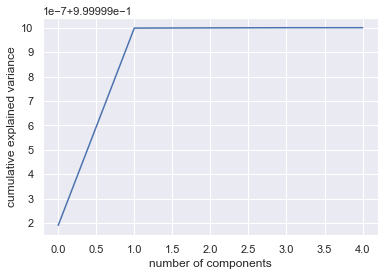

In [39]:
#PCA when we have already scaled down the features manually
pca = PCA().fit(fp[features_to_include])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [40]:
fp

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response
0,0,44,1,28.0,0,2,0,40454.0,26.0,1
1,0,76,1,3.0,0,1,1,33536.0,26.0,0
2,0,47,1,28.0,0,2,0,38294.0,26.0,1
3,0,21,1,11.0,1,0,1,28619.0,152.0,0
4,1,29,1,41.0,1,0,1,27496.0,152.0,0
...,...,...,...,...,...,...,...,...,...,...
381104,0,74,1,26.0,1,1,1,30170.0,26.0,0
381105,0,30,1,37.0,1,0,1,40016.0,152.0,0
381106,0,21,1,30.0,1,0,1,35118.0,160.0,0
381107,1,68,1,14.0,0,2,0,44617.0,124.0,0


In [41]:
fpnr = fp.drop('Response', axis = 1)

In [42]:
fpnr

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel
0,0,44,1,28.0,0,2,0,40454.0,26.0
1,0,76,1,3.0,0,1,1,33536.0,26.0
2,0,47,1,28.0,0,2,0,38294.0,26.0
3,0,21,1,11.0,1,0,1,28619.0,152.0
4,1,29,1,41.0,1,0,1,27496.0,152.0
...,...,...,...,...,...,...,...,...,...
381104,0,74,1,26.0,1,1,1,30170.0,26.0
381105,0,30,1,37.0,1,0,1,40016.0,152.0
381106,0,21,1,30.0,1,0,1,35118.0,160.0
381107,1,68,1,14.0,0,2,0,44617.0,124.0


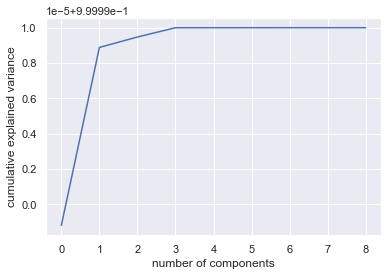

In [43]:
pca = PCA().fit(fpnr)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [44]:

#Build and fit a PCA model to the data
my_pca = PCA(n_components=2)
my_pca.fit(XS)
my_pca_test = PCA(n_components = 2)
#my_pca_test.fit(Xt)
my_pca2 = PCA(n_components= 3)
my_pca2.fit(XS)
#my_pca_test2 = PCA(n_components = 3)
#my_pca_test2.fit(Xt)

#X2_test = PCA(n_components = 2)
#Transform the data
X_PCA = my_pca.transform(XS)
#X_PCA_test = my_pca_test.transform(Xt)
X2_PCA = my_pca2.transform(XS)
#X2_PCA_test = my_pca_test2.transform(Xt)

NameError: name 'XS' is not defined

In [44]:
print(X_PCA)

[[ 1.20224365  0.03672681]
 [ 2.50943954 -0.2035566 ]
 [ 1.31338021 -0.05681788]
 ...
 [-0.97659743  0.22083672]
 [ 1.41569183  0.71374083]
 [ 1.29719845  0.10418913]]


In [45]:
print(abs(my_pca.components_))

[[0.41738763 0.65896853 0.19941224 0.57869542 0.12997854]
 [0.20821783 0.04109291 0.4896834  0.24701481 0.80879575]]


In [46]:
print(my_pca.explained_variance_ratio_)

[0.27066079 0.20219936]


In [47]:
print(my_pca2.explained_variance_ratio_)

[0.27066079 0.20219936 0.19720262]


Text(0, 0.5, 'pca d 2')

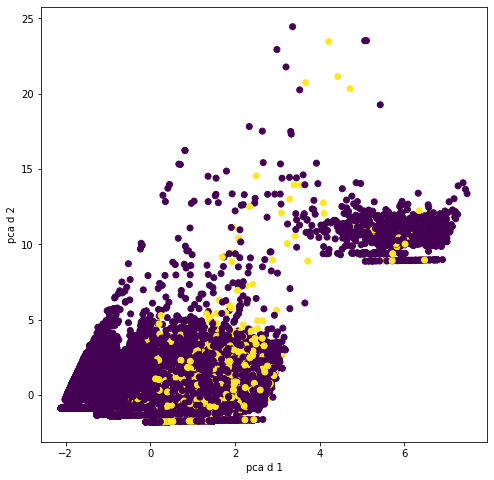

In [48]:
#Ploting the difference in groups determined by PCA. Not a lot of separation
plt.figure(figsize=(8,8))
plt.scatter(X_PCA[:,0], X_PCA[:,1],c=fp['Response'])
plt.xlabel('pca d 1')
plt.ylabel('pca d 2')

In [46]:
X_PCA.shape

(381109, 2)

In [45]:
from sklearn.linear_model import LogisticRegression


In [25]:
import sklearn.pipeline as skpl #I considered using pipeline to move from PCA to logistic regression but abandoned the idea
#for manually moving between the models in order to keep better track of what I was doing

In [28]:
pca = PCA(n_components = 3)

In [29]:
logreg = LogisticRegression()

In [30]:
pipe = skpl.Pipeline(steps =[('pca', pca), ('logreg', logreg)]) 

In [31]:
logreg

LogisticRegression()

In [32]:
pipe

Pipeline(steps=[('pca', PCA(n_components=3)), ('logreg', LogisticRegression())])

In [52]:
y = fp['Response']


In [56]:
train1 = X_PCA
logreg.fit(train1, y)
#This is a poor training model with lots of overfitting. We will try splitting the data and making a training and test set next

LogisticRegression()

In [57]:
logreg.score(X_PCA,y) #Good accuracy

0.8772896992723866

In [46]:
from sklearn.model_selection import train_test_split


In [47]:

X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, test_size=0.4,) #Split up training data and test


NameError: name 'X_PCA' is not defined

In [48]:
Xp_train, Xp_test, yp_train, yp_test = train_test_split(XS,y, test_size = 0.4) #Try scaled data only

NameError: name 'XS' is not defined

In [49]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_PCA, y, test_size=0.2, ) #PCA with 3 components

NameError: name 'X2_PCA' is not defined

In [63]:
#logreg of PCA n_components = 3
logreg2 = LogisticRegression()

logreg2.fit(X2_train, y2_train)
preds2 = logreg2.predict(X2_test)
print(accuracy_score(y2_test, preds2))

0.8780011020440293


In [64]:
logreg.fit(X_train, y_train) #logreg of PCA n_components = 2

LogisticRegression()

In [65]:
preds = logreg.predict(X_test)

In [66]:
print(accuracy_score(y_test, preds)) #Still overfitting????????

0.8777255910367086


In [68]:
y_test.value_counts()

0    133823
1     18621
Name: Response, dtype: int64

In [114]:
okay = pd.read_csv('sample_submissionfp.csv')

In [115]:
okay #The sample submissions responses are all 0's which is one of the reasons I decided to split the train data

,id,Response
0,381110,0
1,381111,0
2,381112,0
3,381113,0
4,381114,0
...,...,...
127032,508142,0
127033,508143,0
127034,508144,0
127035,508145,0


In [84]:
 #accuracy hardly increases with three components
print(accuracy_score(y_test, preds))
print(accuracy_score(y2_test, preds2))
#weird values
#0.9633807473413257
#0.9972711290703471
#0.9397577083841715
#0.997336726929233

0.8777255910367086
0.8780011020440293


In [50]:
from sklearn.metrics import f1_score
#A way of checking a model's performance. 0 is bad, 1 is best.

In [86]:

print(f1_score(y_test, preds))
print(f1_score(y2_test, preds2))
#possible interpretations: One factor is under represented in sample, need to simulate data for higher counts of 
#under represented factor or change weights
#change up test size and random state
#Ideally want f1 score between .6 -> .8


0.000107284626113078
0.0


Poor f1-scores means poor model performance. F1-score is calculated by creating a harmonic mean between precision and recall. Because accuracy score is good for the models but the f-1 score is 0, then the model's recall must be non-existant. What exactly are the models doing?

In [76]:
y_test #Taking a look at the data

230682    0
175136    1
312939    0
298527    0
105098    0
         ..
342871    0
335165    0
210032    0
276813    0
55455     0
Name: Response, Length: 152444, dtype: int32

In [75]:
okay['Response'].value_counts()

0    127037
Name: Response, dtype: int64

In [76]:
okay['Response'].unique() #Only failures are included in validation set. Because of this, I went back to my models
#and split the training data

array([0], dtype=int64)

In [87]:
fp['Response'].value_counts()


0    334399
1     46710
Name: Response, dtype: int64

In [88]:
46710 / 334399 #Checking the percentage of successes in the dataset. This will be important for when we do weighting

0.13968343206767964

In [89]:
print(logreg.coef_)

[[ 0.35170556 -1.37512116 -2.03430791]]


In [53]:
#Abandoning PCA and moving into normal logreg
train3 = fp[features_to_include]
X3_train, X3_test, y3_train, y3_test = train_test_split(train3, y, test_size=0.4, )
logreg3 = LogisticRegression()
y = fp['Response']
logreg3.fit(X3_train, y3_train)


LogisticRegression()

In [37]:
preds3 = logreg3.predict(X3_test)

In [38]:
print(accuracy_score(preds3, y3_test))

0.8774238408858335


In [39]:
print(f1_score(preds3, y3_test)) #Still 0

NameError: name 'f1_score' is not defined

In [94]:
np.set_printoptions(edgeitems = 1000)
print(preds3)
#Checking model predictions. As we can see, there is an abundance of 0's

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [60]:
from sklearn.metrics import roc_auc_score
#Another method of checking a model's performance. We aren't expecting this value to be any better than what we got for
#our f-1 scores

In [96]:
print(roc_auc_score(y_test, preds))
print(roc_auc_score(y2_test, preds2))
print(roc_auc_score(y3_test, preds3))

#Oh no, our model is worthless lets move onto keras

0.4999521258339855
0.5
0.5


In [97]:
fp.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response
0,1,0,44,1,28.0,0,2,0,40454.0,26.0,1
1,2,0,76,1,3.0,0,1,1,33536.0,26.0,0
2,3,0,47,1,28.0,0,2,0,38294.0,26.0,1
3,4,0,21,1,11.0,1,0,1,28619.0,152.0,0
4,5,1,29,1,41.0,1,0,1,27496.0,152.0,0


In [97]:
!pip install catboost

  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11435 sha256=3cbdb0b0929e6720220a5514328f5c20f20c81d2dbf69ae9b6309f9560f620bc
  Stored in directory: c:\users\jason kim\appdata\local\pip\cache\wheels\c4\a7\48\0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying


In [42]:
fp['Response'] = fp['Response'].astype(int)

In [43]:
fp.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response
0,1,0,0.369231,1,28,0,2,0,0.070366,26,1
1,2,0,0.861538,1,3,0,1,1,0.057496,26,0
2,3,0,0.415385,1,28,0,2,0,0.066347,26,1
3,4,0,0.015385,1,11,1,0,1,0.048348,152,0
4,5,1,0.138462,1,41,1,0,1,0.046259,152,0


In [61]:
 from sklearn.metrics import confusion_matrix as cs
    #We want to see how often our model correctly predicted the response. Left column is correct predictions, right column
    # is incorrect. First row is 0, second is 1


Quick rundown of confusion Matrix format:

                Predicted: No , Predicted: Yes
                
Actual:No         
Actual:Yes

In [99]:
cs(y_test, preds, ) #Overfit

array([[133803,     20],
       [ 18620,      1]], dtype=int64)

In [100]:
cs(y2_test, preds2)

array([[66923,     0],
       [ 9299,     0]], dtype=int64)

In [101]:
cs(y3_test, preds3)

array([[133725,      0],
       [ 18719,      0]], dtype=int64)

The confusion matrices confirm that my models are overfitting and why my f-1 scores are so poor. No attempt is made to predict a success (response = 1) for two of my models!

In [102]:
#as we can see from my counts, only model 1 attempts to classify responses as 1's.
print(np.unique(preds, return_counts = True))
print(np.unique(preds2, return_counts = True))
print(np.unique(preds3, return_counts = True))
#My first models achieved great accuracy by predicting every response to be 'No'

(array([0, 1], dtype=int64), array([152423,     21], dtype=int64))
(array([0], dtype=int64), array([76222], dtype=int64))
(array([0], dtype=int64), array([152444], dtype=int64))


What did my first use of keras teach me? It taught me that putting garbage data and methedology into a model returns garbage

In [62]:
#!pip install tensorflow
#!pip install keras 

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
import tensorflow.keras.backend as K

import tensorflow as tf
#Here we try Keras

In [110]:
#I have no idea what I'm doing
#8 digit loss value
epoc = 40 #@param {type:"slider", min:0, max:100, step:1}

#Create Sequential object
model = Sequential()

#Add a dense layers and specify the sigmoid activation function
model.add(Dense(1, input_shape=(6,), activation='sigmoid'))

#Use the SGD optimizer with a lr of 0.5, and use the binary cross entropy loss
model.compile(SGD(lr=0.5), 'binary_crossentropy', metrics=['accuracy'])

model.fit(X4_train, y4_train, epochs=epoc)

Epoch 1/40
7146/7146 [==============================] - 2s 347us/step - loss: 27419450.0000 - accuracy: 0.7814
Epoch 2/40
7146/7146 [==============================] - 2s 338us/step - loss: 27164338.0000 - accuracy: 0.7821
Epoch 3/40
7146/7146 [==============================] - 2s 345us/step - loss: 27221152.0000 - accuracy: 0.7807
Epoch 4/40
7146/7146 [==============================] - 3s 405us/step - loss: 27114206.0000 - accuracy: 0.7817
Epoch 5/40
7146/7146 [==============================] - 3s 410us/step - loss: 27218294.0000 - accuracy: 0.7821
Epoch 6/40
7146/7146 [==============================] - 3s 409us/step - loss: 27294514.0000 - accuracy: 0.7796
Epoch 7/40
7146/7146 [==============================] - 3s 399us/step - loss: 27315894.0000 - accuracy: 0.7806
Epoch 8/40
7146/7146 [==============================] - 3s 375us/step - loss: 27094994.0000 - accuracy: 0.7805
Epoch 9/40
7146/7146 [==============================] - 3s 380us/step - loss: 27095752.0000 - accuracy: 0.7808
E

In [43]:
kpreds = model.predict(X4_test)

NameError: name 'model' is not defined

In [116]:
print(accuracy_score(kpreds, y4_test))
print(f1_score(kpreds, y4_test))
print(roc_auc_score(y4_test, kpreds))
#Great accuracy score but performance measures are awful

0.877541917031828
0.0
0.5


How do we turn our garbage into gold? The trick is to fix the performance between each epoch by calculating the f-1 score between each iteration and optimizing for increasing the f-1 score

In [63]:
from keras.layers import Dropout        
from tensorflow.keras.utils import to_categorical


In [64]:
#Using stack overflow we find a method of fixing the performance of the model through each epoch
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    #true_positives and possible_positives seem to be misnamed
    return recall
#Sum up the rounded 'clipped' value of y_true multiplied by y_pred, where y_true and y_pred are bounded between 0 and 1
# Because this is log regression, clipping should be redundant as all values are 0 or 1 and any misentered responses should be
#removed during data cleaning
#Recall is 1 when there are no false negatives, lower when there are

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
#Precision is 1 when predicted = true positives
#however unlike recall, precision is looking at how accurately the model predicted positives. It gets lower when there
#are false positives, not false negatives
def keras_f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [65]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(
        loss=tf.keras.losses.binary_crossentropy, 
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[keras_f1_score]
    )
    return model

In [66]:
XK = fp[features_to_include]
y = fp['Response']

In [67]:
XK_train, XK_test, yk_train, yk_test = train_test_split(XK, y, test_size=0.2,)

In [68]:
y_nn_train = to_categorical(yk_train)

In [69]:
class_weight = {
    0: 1.,
    1: 8.
}
# We give success 8x the weight because they are ~12% of the responses, a.k.a about 1/8 of the responses

In [70]:
model = create_model()
model.fit(XK_train, y_nn_train, validation_split=0.2, epochs=35, batch_size=256, verbose=2, class_weight=class_weight)

Epoch 1/35
953/953 - 1s - loss: 0.9441 - keras_f1_score: 0.6287 - val_loss: 0.5725 - val_keras_f1_score: 0.5910
Epoch 2/35
953/953 - 1s - loss: 0.8584 - keras_f1_score: 0.6334 - val_loss: 0.5205 - val_keras_f1_score: 0.6298
Epoch 3/35
953/953 - 1s - loss: 0.8499 - keras_f1_score: 0.6357 - val_loss: 0.5263 - val_keras_f1_score: 0.6356
Epoch 4/35
953/953 - 1s - loss: 0.8469 - keras_f1_score: 0.6371 - val_loss: 0.5156 - val_keras_f1_score: 0.6469
Epoch 5/35
953/953 - 1s - loss: 0.8437 - keras_f1_score: 0.6374 - val_loss: 0.5259 - val_keras_f1_score: 0.6313
Epoch 6/35
953/953 - 1s - loss: 0.8433 - keras_f1_score: 0.6371 - val_loss: 0.5509 - val_keras_f1_score: 0.6256
Epoch 7/35
953/953 - 1s - loss: 0.8430 - keras_f1_score: 0.6371 - val_loss: 0.5285 - val_keras_f1_score: 0.6271
Epoch 8/35
953/953 - 1s - loss: 0.8416 - keras_f1_score: 0.6374 - val_loss: 0.5245 - val_keras_f1_score: 0.6431
Epoch 9/35
953/953 - 1s - loss: 0.8419 - keras_f1_score: 0.6373 - val_loss: 0.5193 - val_keras_f1_score:

In [71]:
predsk = model.predict(XK_test)
predsk = np.argmax(predsk, axis=1)

In [72]:
print(accuracy_score(predsk, yk_test))
print(f1_score(yk_test, predsk))
print(roc_auc_score(yk_test, predsk))
# Accuracy takes a hit but our model is no longer overfitted and now predicts correctly instead of assigning 0's to every input

0.6527774133452284
0.40040779338468513
0.7736605489033316


In [73]:
cs(yk_test, predsk, ) #now it looks like successes are overweighted. Could alter weights to see better results

array([[40919, 25846],
       [  620,  8837]], dtype=int64)

In [74]:
class_weight2 = {
    0: 1.,
    1: 7.
}
#Actually, the proportions are closer to 7:1, so lets make a second model with the updated class weight

In [75]:
model2 = create_model()
model2.fit(XK_train, y_nn_train, validation_split=0.2, epochs=35, batch_size=256, verbose=2, class_weight=class_weight2)

Epoch 1/35
953/953 - 1s - loss: 0.9028 - keras_f1_score: 0.6485 - val_loss: 0.4959 - val_keras_f1_score: 0.6579
Epoch 2/35
953/953 - 1s - loss: 0.8060 - keras_f1_score: 0.6509 - val_loss: 0.4910 - val_keras_f1_score: 0.6474
Epoch 3/35
953/953 - 1s - loss: 0.8007 - keras_f1_score: 0.6514 - val_loss: 0.4854 - val_keras_f1_score: 0.6558
Epoch 4/35
953/953 - 1s - loss: 0.7991 - keras_f1_score: 0.6524 - val_loss: 0.5049 - val_keras_f1_score: 0.6383
Epoch 5/35
953/953 - 1s - loss: 0.7972 - keras_f1_score: 0.6517 - val_loss: 0.4974 - val_keras_f1_score: 0.6643
Epoch 6/35
953/953 - 1s - loss: 0.7956 - keras_f1_score: 0.6538 - val_loss: 0.4734 - val_keras_f1_score: 0.6620
Epoch 7/35
953/953 - 1s - loss: 0.7952 - keras_f1_score: 0.6520 - val_loss: 0.4870 - val_keras_f1_score: 0.6616
Epoch 8/35
953/953 - 1s - loss: 0.7954 - keras_f1_score: 0.6525 - val_loss: 0.4980 - val_keras_f1_score: 0.6589
Epoch 9/35
953/953 - 1s - loss: 0.7950 - keras_f1_score: 0.6530 - val_loss: 0.4926 - val_keras_f1_score:

In [76]:
predsk2 = model2.predict(XK_test)
predsk2 = np.argmax(predsk2, axis=1)

In [77]:
print(accuracy_score(predsk2, yk_test))
print(f1_score(yk_test, predsk2))
print(roc_auc_score(yk_test, predsk2))
#values from when I included 6 features instead of 5. Model performance takes a hit but now I no longer use variables heavily
#correlated with each other giving more stable results and less nonsense coefficients for our model parameters
#0.69376295557713
#0.4240525069088038
#0.792829730451888


0.661108341423736
0.4039779413461317
0.7746493339158833


In [78]:
cs(yk_test, predsk2, )

array([[41637, 25128],
       [  703,  8754]], dtype=int64)

In [79]:
print(model2.get_weights())

[array([0.57460356, 1.0736587 , 0.25681537, 1.2206343 , 0.24287163],
      dtype=float32), array([-0.10366635,  0.0641347 ,  0.0103442 , -0.41549972,  0.01775232],
      dtype=float32), array([4.6070930e-01, 3.8881657e+01, 9.9807489e-01, 4.5447725e-01,
       3.0582746e+04], dtype=float32), array([2.4739379e-01, 2.4095769e+02, 1.9134131e-03, 2.4689648e-01,
       2.9789034e+08], dtype=float32), array([[ 0.09157148, -0.02849174,  0.12443691,  0.48714206, -0.05219379,
        -0.5312495 ,  0.06082968,  0.03634905,  0.05682493, -0.512599  ,
         0.03785536,  0.07597565, -0.01613114, -0.37515077,  0.03455433,
        -0.00473614, -0.05945899, -0.30497575,  0.47156864, -0.19304515,
        -0.0124439 , -0.01813813,  0.04326029, -0.36671743,  0.02121428,
        -0.04102181,  0.07091012,  0.04956697, -0.0143817 ,  0.06555327],
       [ 0.65710557, -0.12406678, -0.0203325 , -0.3647766 , -0.078789  ,
         0.14074494,  0.20659038,  0.27505434, -0.5505666 , -0.10314042,
         0.016044

With the use of Keras, I have improved the performance of my model through iterative optimizing of the f-1 score

I want to return to PCA using Keras and also with a new approach to training the data. Previously, I scaled the data before the train/test split which is incorrect. This time, I will scale the training set after splitting the data. Why should we do this? Transforming the data transforms the domain. If you transform the entire data set, you are causing overfitting as both the train and test data are shifted into the same domain. This will make your model unreliable when ran against new data.

In [80]:
#I don't think this is necessary when using Keras to run the model
import statsmodels.api as sm
from statsmodels.api import OLS

In [81]:
X_train, X_test, y_train, y_test = train_test_split(fpnr, y, test_size=0.4,) #Split up training data and test

#Code borrowed from Harvard's CS109A Introduction to Data Science
#Create and fit PCA object
pca = PCA(n_components=3)
pca.fit(X_train)

#Transforming x_train and x_test 
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

#Add constant to x_train and x_test
#I don't need this. Actually, I'm not even sure why it was needed. Does it add an intercept? How does it work with Keras?
X_train_pca_cst = sm.add_constant(X_train_pca)
X_test_pca_cst = sm.add_constant(X_test_pca)

#Training
model = LogisticRegression(C=100000).fit(X_train_pca_cst, y_train)

#Predict
y_pred_train = model.predict(X_train_pca_cst)
y_pred_test = model.predict(X_test_pca_cst)

#Perfromance Evaluation
train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Testing Set Accuracy:",str(test_score)+'%')

Training Set Accuracy: 87.72614960750444%
Testing Set Accuracy: 87.76993518931542%


In [82]:
print(f1_score(y_pred_test, y_test))

0.0


In [83]:
print(roc_auc_score(y_test, y_pred_test))

0.5


In [84]:
y_nn_train2 = to_categorical(y_train)

In [85]:
def create_model2():
    modelo = tf.keras.Sequential([
        tf.keras.layers.Input(3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    modelo.compile(
        loss=tf.keras.losses.binary_crossentropy, 
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[keras_f1_score]
    )
    return modelo

In [86]:
modelpca = create_model2()
modelpca.fit(X_train_pca, y_nn_train2, validation_split=0.2, epochs=35, batch_size=256, verbose=2, class_weight=class_weight2)

Epoch 1/35
715/715 - 1s - loss: 1.2305 - keras_f1_score: 0.5763 - val_loss: 0.6475 - val_keras_f1_score: 0.5630
Epoch 2/35
715/715 - 1s - loss: 1.1331 - keras_f1_score: 0.5701 - val_loss: 0.6433 - val_keras_f1_score: 0.5692
Epoch 3/35
715/715 - 1s - loss: 1.1298 - keras_f1_score: 0.5663 - val_loss: 0.6323 - val_keras_f1_score: 0.5624
Epoch 4/35
715/715 - 1s - loss: 1.1289 - keras_f1_score: 0.5692 - val_loss: 0.6338 - val_keras_f1_score: 0.5533
Epoch 5/35
715/715 - 1s - loss: 1.1279 - keras_f1_score: 0.5696 - val_loss: 0.6457 - val_keras_f1_score: 0.5327
Epoch 6/35
715/715 - 1s - loss: 1.1278 - keras_f1_score: 0.5661 - val_loss: 0.6382 - val_keras_f1_score: 0.5716
Epoch 7/35
715/715 - 1s - loss: 1.1252 - keras_f1_score: 0.5649 - val_loss: 0.6456 - val_keras_f1_score: 0.5475
Epoch 8/35
715/715 - 1s - loss: 1.1249 - keras_f1_score: 0.5634 - val_loss: 0.6349 - val_keras_f1_score: 0.5899
Epoch 9/35
715/715 - 1s - loss: 1.1245 - keras_f1_score: 0.5675 - val_loss: 0.6375 - val_keras_f1_score:

In [88]:
predspca = modelpca.predict(X_test_pca)
predspca= np.argmax(predspca, axis=1)

In [89]:
print(accuracy_score(predspca, y_test))
print(f1_score(y_test, predspca))
print(roc_auc_score(y_test, predspca))
#Values without the constant 
#0.5849557870431109
#0.30109688608070345
#0.6474239066041656

0.5533900973472226
0.29463018410501346
0.6434442110839909


In [90]:
X_train_pca_cst

array([[ 1.00000000e+00,  5.28675844e+03,  4.36990950e+01,
         2.93297603e+00],
       [ 1.00000000e+00,  1.24267694e+04,  1.51295634e+01,
         3.35501756e+00],
       [ 1.00000000e+00, -3.39924092e+03,  4.03505388e+01,
         2.99699629e+00],
       ...,
       [ 1.00000000e+00, -2.20924048e+03,  4.01220903e+01,
        -1.97685569e+01],
       [ 1.00000000e+00, -5.07324091e+03,  4.01085923e+01,
         6.78277804e-01],
       [ 1.00000000e+00, -2.79022394e+04,  3.20752497e+01,
        -1.15791522e+01]])

In [91]:
X2_train, X2_test, y2_train, y2_test = train_test_split(fpnr, y, test_size=0.2, )

In [94]:
scaler = StandardScaler()
scaler.fit(X2_train)
XS = scaler.transform(X2_train)


In [95]:
scaler.fit(X2_test)
XST = scaler.transform(X2_test)


In [96]:
def create_model3():
    model3 = tf.keras.Sequential([
        tf.keras.layers.Input(3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model3.compile(
        loss=tf.keras.losses.binary_crossentropy, 
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[keras_f1_score]
    )
    return model3

In [97]:
pca2 = PCA(n_components=3)
pca2.fit(XS)

#Transforming x_train and x_test 
XS_train_pca = pca2.transform(XS)
XS_test_pca = pca2.transform(XST)

In [98]:
y_nn_train3 = to_categorical(y2_train)

In [99]:
modelpca = create_model3()
modelpca.fit(XS_train_pca, y_nn_train3, validation_split=0.2, epochs=35, batch_size=256, verbose=2, class_weight=class_weight2)

Epoch 1/35
953/953 - 1s - loss: 0.8257 - keras_f1_score: 0.6662 - val_loss: 0.5090 - val_keras_f1_score: 0.6654
Epoch 2/35
953/953 - 1s - loss: 0.7839 - keras_f1_score: 0.6734 - val_loss: 0.4772 - val_keras_f1_score: 0.6757
Epoch 3/35
953/953 - 1s - loss: 0.7792 - keras_f1_score: 0.6734 - val_loss: 0.4878 - val_keras_f1_score: 0.6757
Epoch 4/35
953/953 - 1s - loss: 0.7780 - keras_f1_score: 0.6736 - val_loss: 0.4829 - val_keras_f1_score: 0.6680
Epoch 5/35
953/953 - 1s - loss: 0.7754 - keras_f1_score: 0.6738 - val_loss: 0.4674 - val_keras_f1_score: 0.6812
Epoch 6/35
953/953 - 1s - loss: 0.7757 - keras_f1_score: 0.6749 - val_loss: 0.4840 - val_keras_f1_score: 0.6689
Epoch 7/35
953/953 - 1s - loss: 0.7760 - keras_f1_score: 0.6739 - val_loss: 0.4973 - val_keras_f1_score: 0.6776
Epoch 8/35
953/953 - 1s - loss: 0.7744 - keras_f1_score: 0.6738 - val_loss: 0.4781 - val_keras_f1_score: 0.6880
Epoch 9/35
953/953 - 1s - loss: 0.7740 - keras_f1_score: 0.6734 - val_loss: 0.4660 - val_keras_f1_score:

In [100]:
predspca2 = modelpca.predict(XS_test_pca)
predspca2 = np.argmax(predspca2,axis = 1 )

In [101]:
print(accuracy_score(predspca2, y2_test))
print(f1_score(y2_test, predspca2))
print(roc_auc_score(y2_test, predspca2))
#Out performs the non-scaled PCA model and the supervized learning model!
#Seems impressive until you realize that we kept in more features that were
#correlated with each other. Less meaningful interpretibility

0.6695048673611294
0.41069548740262474
0.788500437873026


In [102]:
fpnr

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel
0,0,44,1,28.0,0,2,0,40454.0,26.0
1,0,76,1,3.0,0,1,1,33536.0,26.0
2,0,47,1,28.0,0,2,0,38294.0,26.0
3,0,21,1,11.0,1,0,1,28619.0,152.0
4,1,29,1,41.0,1,0,1,27496.0,152.0
...,...,...,...,...,...,...,...,...,...
381104,0,74,1,26.0,1,1,1,30170.0,26.0
381105,0,30,1,37.0,1,0,1,40016.0,152.0
381106,0,21,1,30.0,1,0,1,35118.0,160.0
381107,1,68,1,14.0,0,2,0,44617.0,124.0


In [103]:
X3_train, X3_test, y3_train, y3_test = train_test_split(fpnr[features_to_include], y, test_size=0.2, )

In [104]:
scaler.fit(X3_train)
XS3 = scaler.transform(X3_train)


In [105]:
scaler.fit(X3_test)
XS3T = scaler.transform(X3_test)


In [106]:
pca3 = PCA(n_components=3)
pca3.fit(XS3)

#Transforming x_train and x_test 
XS2_train_pca = pca3.transform(XS3)
XS2_test_pca = pca3.transform(XS3T)

In [107]:
y_nn_train4 = to_categorical(y3_train)

In [108]:
modelpca = create_model3()
modelpca.fit(XS2_train_pca, y_nn_train4, validation_split=0.2, epochs=35, batch_size=256, verbose=2, class_weight=class_weight2)

Epoch 1/35
953/953 - 1s - loss: 0.9738 - keras_f1_score: 0.6317 - val_loss: 0.5081 - val_keras_f1_score: 0.6241
Epoch 2/35
953/953 - 1s - loss: 0.9169 - keras_f1_score: 0.6320 - val_loss: 0.4973 - val_keras_f1_score: 0.6279
Epoch 3/35
953/953 - 1s - loss: 0.9110 - keras_f1_score: 0.6286 - val_loss: 0.5043 - val_keras_f1_score: 0.6097
Epoch 4/35
953/953 - 1s - loss: 0.9070 - keras_f1_score: 0.6309 - val_loss: 0.4858 - val_keras_f1_score: 0.6423
Epoch 5/35
953/953 - 1s - loss: 0.9052 - keras_f1_score: 0.6304 - val_loss: 0.4992 - val_keras_f1_score: 0.6242
Epoch 6/35
953/953 - 1s - loss: 0.9026 - keras_f1_score: 0.6319 - val_loss: 0.5002 - val_keras_f1_score: 0.6263
Epoch 7/35
953/953 - 1s - loss: 0.9045 - keras_f1_score: 0.6353 - val_loss: 0.5033 - val_keras_f1_score: 0.6221
Epoch 8/35
953/953 - 1s - loss: 0.8988 - keras_f1_score: 0.6364 - val_loss: 0.4939 - val_keras_f1_score: 0.6307
Epoch 9/35
953/953 - 1s - loss: 0.8986 - keras_f1_score: 0.6368 - val_loss: 0.4644 - val_keras_f1_score:

In [109]:
predspca3 = modelpca.predict(XS2_test_pca)
predspca3 = np.argmax(predspca3,axis = 1 )

In [110]:
print(accuracy_score(predspca3, y3_test))
print(f1_score(y3_test, predspca3))
print(roc_auc_score(y3_test, predspca3))
#0.17519876151242422
#0.2055300005054845
#0.4716725856226549

0.6092335546167773
0.36120702597207627
0.7332526983883134


In [111]:
print(accuracy_score(predspca2, y2_test))
print(f1_score(y2_test, predspca2))
print(roc_auc_score(y2_test, predspca2))
#compare 

0.6695048673611294
0.41069548740262474
0.788500437873026


Final test without weights

In [116]:
model = create_model()
model.fit(XK_train, y_nn_train, validation_split=0.2, epochs=35, batch_size=256, verbose=2, )

Epoch 1/35
953/953 - 1s - loss: 0.3664 - keras_f1_score: 0.8344 - val_loss: 0.2801 - val_keras_f1_score: 0.8788
Epoch 2/35
953/953 - 1s - loss: 0.2875 - keras_f1_score: 0.8773 - val_loss: 0.2782 - val_keras_f1_score: 0.8788
Epoch 3/35
953/953 - 1s - loss: 0.2839 - keras_f1_score: 0.8775 - val_loss: 0.2780 - val_keras_f1_score: 0.8788
Epoch 4/35
953/953 - 1s - loss: 0.2837 - keras_f1_score: 0.8776 - val_loss: 0.2779 - val_keras_f1_score: 0.8788
Epoch 5/35
953/953 - 1s - loss: 0.2831 - keras_f1_score: 0.8776 - val_loss: 0.2772 - val_keras_f1_score: 0.8788
Epoch 6/35
953/953 - 1s - loss: 0.2830 - keras_f1_score: 0.8776 - val_loss: 0.2771 - val_keras_f1_score: 0.8788
Epoch 7/35
953/953 - 1s - loss: 0.2830 - keras_f1_score: 0.8776 - val_loss: 0.2771 - val_keras_f1_score: 0.8788
Epoch 8/35
953/953 - 1s - loss: 0.2823 - keras_f1_score: 0.8776 - val_loss: 0.2772 - val_keras_f1_score: 0.8788
Epoch 9/35
953/953 - 1s - loss: 0.2826 - keras_f1_score: 0.8776 - val_loss: 0.2777 - val_keras_f1_score:

In [118]:
predsknoweights = model2.predict(XK_test)
predsknoweights = np.argmax(predsknoweights, axis=1)

In [119]:
print(accuracy_score(predsknoweights, yk_test))
print(f1_score(yk_test, predsknoweights))
print(roc_auc_score(yk_test, predsknoweights))

0.661108341423736
0.4039779413461317
0.7746493339158833


In [120]:
cs(yk_test, predsknoweights)

array([[41637, 25128],
       [  703,  8754]], dtype=int64)

Problems with converting my notebook file into a pdf for upload purposes

In [55]:
!pip install nbconvert

In [56]:
!export PATH=/Library/TeX/texbin:$PATH

'export' is not recognized as an internal or external command,
operable program or batch file.


In [58]:
import nbconvert

In [59]:
 jupyter nbconvert FinalProject.ipynb --to pdf

SyntaxError: invalid syntax (<ipython-input-59-5097655e60f4>, line 1)

Forget about fixing PATH, just press ctrl+p in your browser and save as a pdf 